## Visualize the visits overlapping a single point on the sky



In [1]:
# Some modules you're likely to want .. add whatever is needed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline   
# %matplotlib notebook

In [2]:
# Import MAF
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils

Use the current baseline simulation included with $RUBIN_SIM_DATA_DIR

In [3]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/Users/lynnej/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db
baseline_v2.1_10yrs


And let's set up a slicer that will give us the observations that overlap a single point on the sky.

In [4]:
# Specify ra / dec of the point we want to work with on the sky - in degrees. 
# (these can be lists, if you want to work on multiple, limited points on the sky)
test_ra = 0.0
test_dec = -20.0
test_slicer = maf.UserPointsSlicer(test_ra, test_dec)

Using the 'Pass' metric will just return these columns from the database. 

In [78]:
# Set up the metric
cols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotTelPos', 'rotSkyPos', 'filter', 'night']
mymetric = maf.PassMetric(cols=cols)

In [79]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
sqlconstraint = None   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
# sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 365'  # only use visits in the first year of the survey

In [80]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint, runName=runName)

In [81]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_fname, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying table None with no constraint for columns ['night', 'fieldDec', 'rotSkyPos', 'rotTelPos', 'filter', 'observationStartMJD', 'fieldRA'].
Found 2081749 visits
Running:  ['test_metric']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


And then you can look at the `bundle.metricValues` to see what your metric calculated and how well things worked.

In [89]:
bundle.metricValues[0][0:2]

rec.array([(1869, -21.44760538, -64.14716119, 48.20257096, 'g', 62087.15764973, 358.93416218),
           (1869, -21.44760538, -64.14716119, 50.138314  , 'u', 62087.13343296, 358.93416218)],
          dtype=[('night', '<i8'), ('fieldDec', '<f8'), ('rotSkyPos', '<f8'), ('rotTelPos', '<f8'), ('filter', 'O'), ('observationStartMJD', '<f8'), ('fieldRA', '<f8')])

In [91]:
# g.simData is the simulation visit data that the previous MetricBundleGroup queried from the database 
# -- so in this case, because of the "Pass" metric, it's just another way to access the same information as 'bundle.metricValues'
g.simData[0:2]

rec.array([(0, -60.81292802, -297.24922531, 43.83296777, 'y', 60218.00180556, 310.0244801 ),
           (0, -63.56142457, -297.70827792, 45.04043979, 'y', 60218.00225414, 310.60187065)],
          dtype=[('night', '<i8'), ('fieldDec', '<f8'), ('rotSkyPos', '<f8'), ('rotTelPos', '<f8'), ('filter', 'O'), ('observationStartMJD', '<f8'), ('fieldRA', '<f8')])

So let's try to visualize the visits

In [92]:
visits = bundle.metricValues[0]

Text(0.5, 0, 'Distance from center of FOV (deg)')

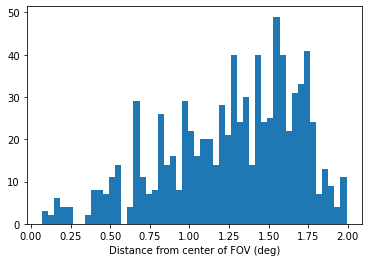

In [93]:
# How far is the center of each visit from the point on the sky? (radius is in degrees)
radius = rsUtils.angularSeparation(visits['fieldRA'], visits['fieldDec'], test_ra, test_dec)
n,b,p = plt.hist(radius, bins=50)
plt.xlabel("Distance from center of FOV (deg)")

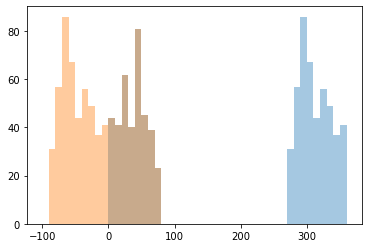

In [94]:
# what is the camera rotation angle (should run -90 to +90 but scheduler outputs map into 0-360)
rotAngle = visits['rotTelPos'] 
n,b,p = plt.hist(rotAngle, bins=np.arange(-100, 370, 10), alpha=0.4)
rotAngle = np.where(visits['rotTelPos'] > 180, visits['rotTelPos']%180-180, visits['rotTelPos'])
n,b,p = plt.hist(rotAngle, bins=b, alpha=0.4)

Text(0.5, 0, 'Rotator angle (deg)')

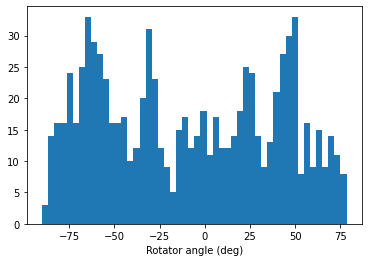

In [95]:
n,b,p = plt.hist(rotAngle, bins=50)
plt.xlabel('Rotator angle (deg)')

Text(0.5, 0, 'Rot Sky Pos (deg)')

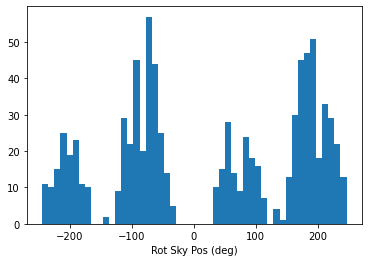

In [96]:
# Angle between "north" and the top of the FOV
n,b,p = plt.hist(visits['rotSkyPos'], bins=50)
plt.xlabel("Rot Sky Pos (deg)")

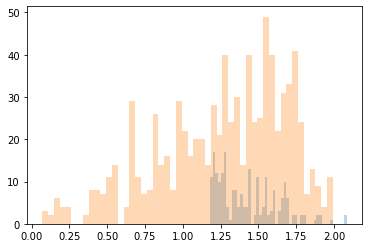

In [97]:
x, y = rsUtils.gnomonic_project_toxy(np.radians(visits['fieldRA']), 
                                      np.radians(visits['fieldDec']), 
                                      np.radians(test_ra), 
                                      np.radians(test_dec))
x = np.degrees(x)
y = np.degrees(y)
rad = np.sqrt(x**x + y**y)
n,b,p = plt.hist(rad, bins=50, alpha=0.3)
n,b,p = plt.hist(radius, bins=50, alpha=0.3)
# I don't quite understand this, but the plot of x/y looks ok next?

14


(-5.0, 5.0)

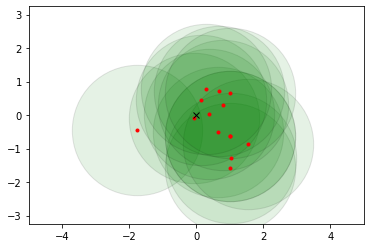

In [109]:
show = np.where((visits['filter'] == 'r') & (visits['night'] < 367))
print(len(show[0]))

fig,ax = plt.subplots()
ax.axis('equal')
# These are just the center of the pointings - replace with patches
#plt.plot(x, y, 'k.')
# Might be able to do a hack?
#plt.scatter([0], [0], s=10000, 
#            #marker='o', markersize=100, linestyle=''
#            edgecolor='black', facecolor='red', alpha=0.2)
plt.scatter(x[show], y[show], s=17000, 
            #marker='o', markersize=100, linestyle=''
            edgecolor='black', facecolor='green', alpha=0.1)
plt.plot(x[show], y[show], marker='.', markersize=6, linestyle='', color='r')
plt.plot([0], [0], marker='x', linestyle='', color='k')
plt.xlim(-5, 5)
plt.ylim(-5, 5)